In [1]:
import os
import load_dataset
import torch.nn as nn
import clip
import torch
import pyarrow as pa
import lancedb
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from IPython.display import display


device = "cuda" if torch.cuda.is_available() else "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)

os.environ['EXTRACT_DIR'] = "/tmp/GLAMI-1M/"
load_dataset.download_dataset(dataset_url="https://huggingface.co/datasets/glami/glami-1m/resolve/main/GLAMI-1M-dataset--test-only.zip")

In [2]:
df_infer = load_dataset.get_dataframe('test')[['category_name', 'image_file']]
df_infer = df_infer.drop_duplicates(subset=['image_file'])[['category_name', 'image_file']].reset_index(drop=True)

# 16 of ram is not enough for the entire images after preprocess
# so only takes 30000 images 
df_infer = df_infer[:30000]

In [3]:
# load pretrained model
model = torch.load('model_storage/pretrained_clip.pt')

## Batch inference

In [4]:
images_list = []

for image in tqdm(df_infer.image_file):
    images_list.append(Image.open(image).convert('RGB'))

100%|███████████████████████████████████| 30000/30000 [00:22<00:00, 1348.30it/s]


In [5]:
class FashionInfer(Dataset):
    def __init__(self, images_list):
        self.images_list = images_list
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        image_tensor = preprocess(images_list[idx])
        return image_tensor

In [6]:
dataset = FashionInfer(images_list)
data_loader = DataLoader(dataset, batch_size=32)

In [7]:
# perform batch inference for create images embedding, it may takes 15 minutes 
embedding_images = []

model.eval()
for images_tensor in tqdm(data_loader):
    images_tensor = images_tensor.to(device)
    embedding_image = model.encode_image(images_tensor)
    embedding_images.extend([i.tolist() for i in embedding_image.detach().cpu().numpy()])

100%|█████████████████████████████████████████| 938/938 [15:27<00:00,  1.01it/s]


## Connect to the LanceDB table

In [8]:
db = lancedb.connect('./data/tables')
schema = pa.schema(
  [
      pa.field("vector", pa.list_(pa.float32(), 512)),
      pa.field("id", pa.int32())
  ])
tbl = db.create_table("fashion_images", schema=schema, mode="overwrite")

In [9]:
data = []
for i in range(len(embedding_images)):
    data.append({'vector': embedding_images[i], 'id': i})
    
# add data to the LanceDB table
tbl.add(data)
tbl.to_pandas()

## Test retrieval

In [ ]:
def image2embs(image_file):
    image = preprocess(Image.open(image_file).convert('RGB')).unsqueeze(0).to(device)
    embs = model.encode_image(image)
    return embs.detach().cpu().numpy()[0].tolist()

def text2emb(text_query):
    text_token = clip.tokenize(text_query)
    text_emb = model.encode_text(text_token.to(device))
    return text_emb.detach().cpu().numpy()[0].tolist()

def search(input_emb, n_candidates):
    res = tbl.search(input_emb).limit(n_candidates).to_df()
    match_id = res.id.values.tolist()
    return match_id

### image query input

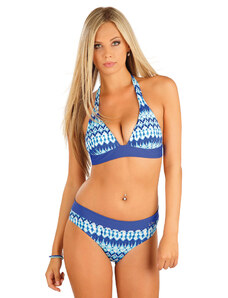

In [131]:
# image from vector database
i = random.randint(0, 30000)
images_query = df_infer.image_file[i]
Image.open(images_query).convert('RGB')

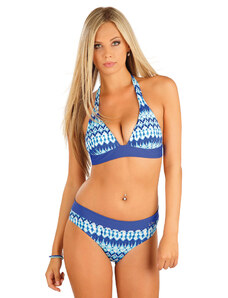

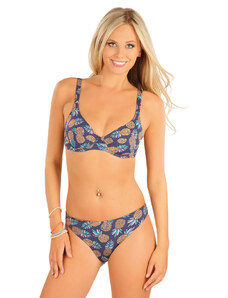

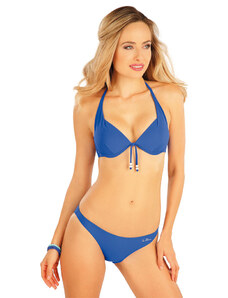

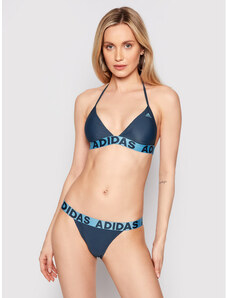

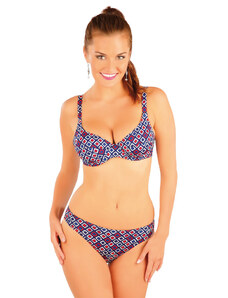

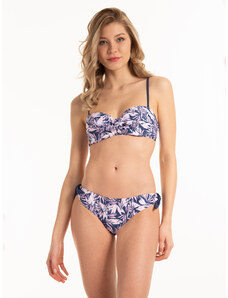

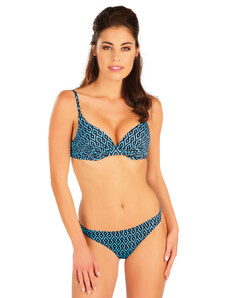

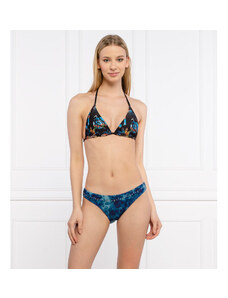

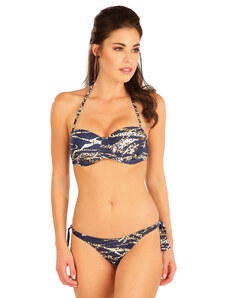

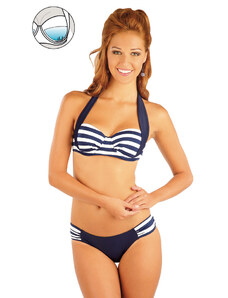

In [132]:
image_emb = image2embs(images_query)
match_id = search(image_emb, n_candidates=10)

for i in match_id:
    display(Image.open(df_infer.image_file[i]).convert('RGB'))

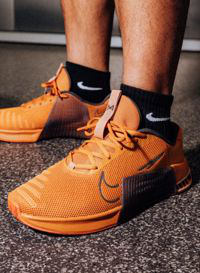

In [81]:
# image from user
Image.open('data/men-s-shoes-clothing-accessories.jpg').convert('RGB')

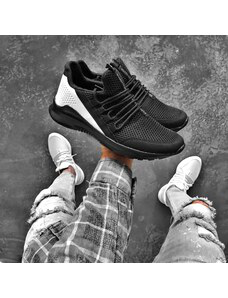

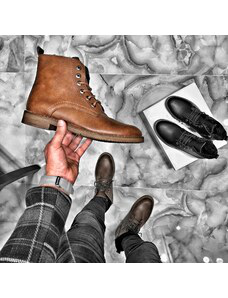

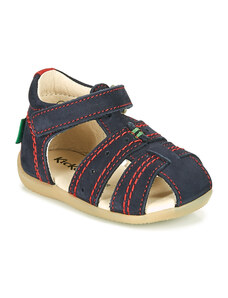

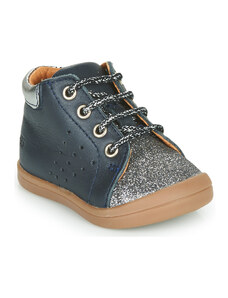

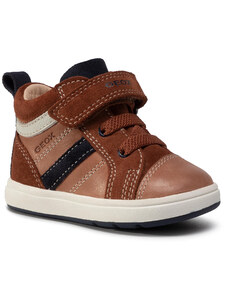

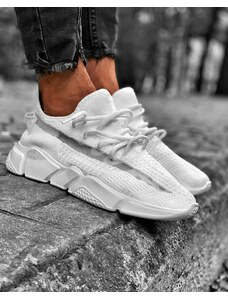

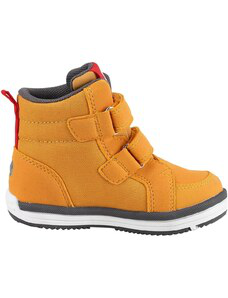

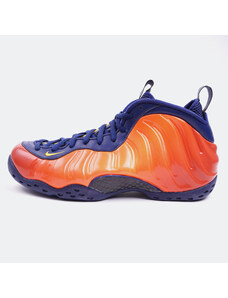

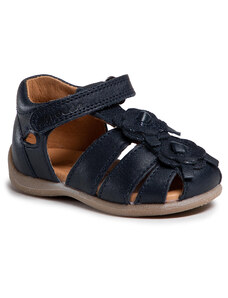

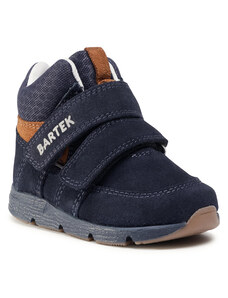

In [130]:
user_image = 'data/men-s-shoes-clothing-accessories.jpg'
image_emb = image2embs(user_image)
match_id = search(image_emb, n_candidates=10)

for i in match_id:
    display(Image.open(df_infer.image_file[i]).convert('RGB'))

### text input query

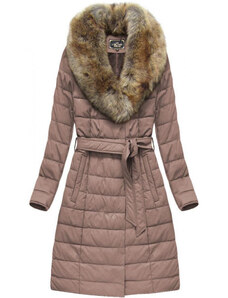

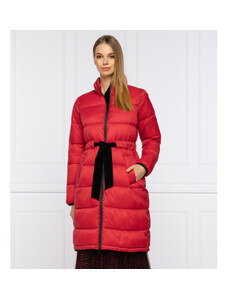

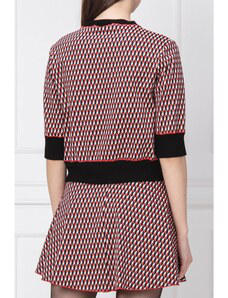

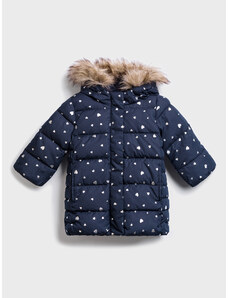

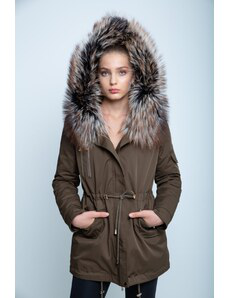

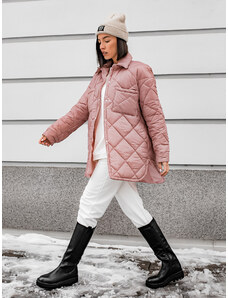

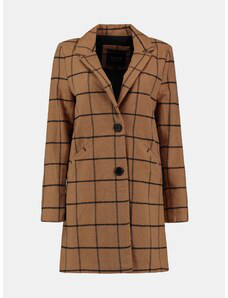

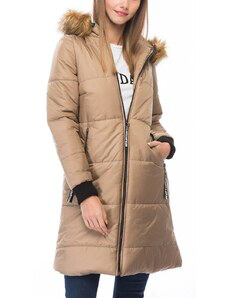

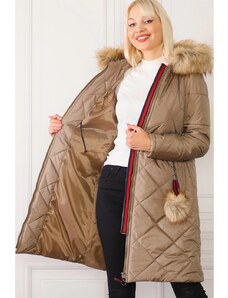

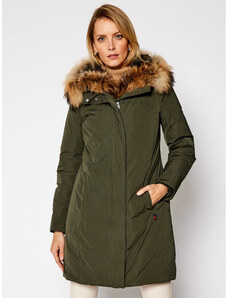

In [128]:
text_query = 'women coat'
text_emb = text2emb(text_query)
match_id = search(text_emb, n_candidates=10)
for i in match_id:
    display(Image.open(df_infer.image_file[i]).convert('RGB'))

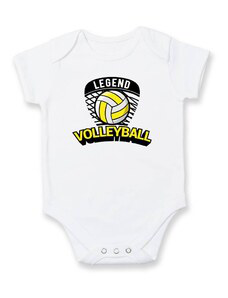

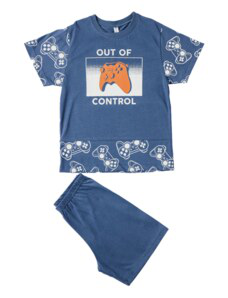

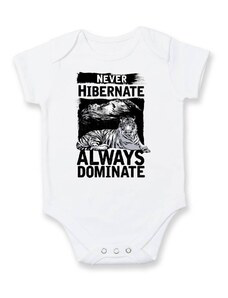

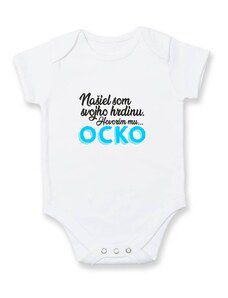

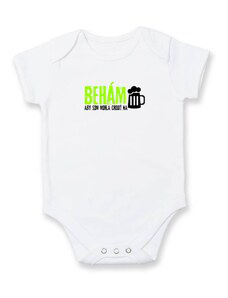

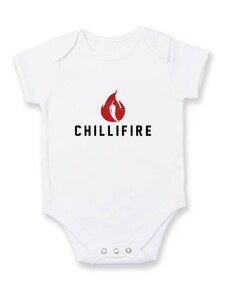

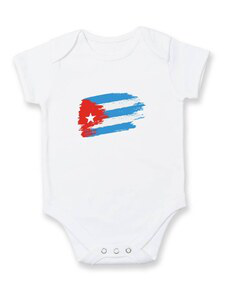

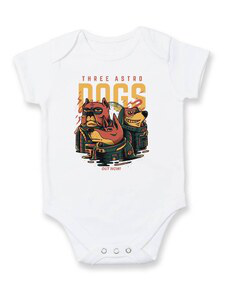

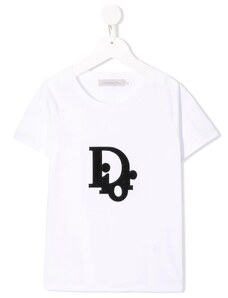

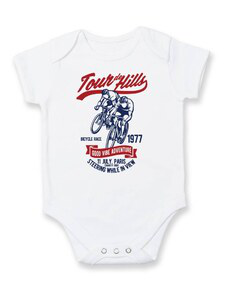

In [129]:
text_query = 'baby t-shirt'
text_emb = text2emb(text_query)
match_id = search(text_emb, n_candidates=10)

for i in range(10):
    match_id = res.id.values[i]
    display(Image.open(df_infer.image_file[match_id]).convert('RGB'))